,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


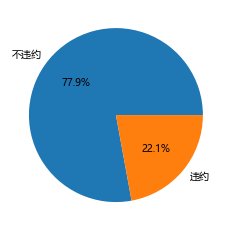

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 读入数据
default = pd.read_excel(r'default of credit card clients.xls')
display(default.head(5))

# 数据集中是否违约的客户比例
# 为确保绘制的饼图为圆形，需执行如下代码
plt.axes(aspect = 'equal')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
# 统计客户是否违约的频数
counts = default.y.value_counts()
# 绘制饼图
plt.pie(x = counts, # 绘图数据
        labels=pd.Series(counts.index).map({0:'不违约',1:'违约'}), # 添加文字标签
        autopct='%.1f%%' # 设置百分比的格式，这里保留一位小数
       )
plt.show()

In [2]:
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

X = default.drop(['ID','y'], axis = 1)
y = default.y
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.25, random_state = 1234)

# AdaBoost
AdaBoost1 = ensemble.AdaBoostClassifier()
AdaBoost1.fit(X_train,y_train)
pred1 = AdaBoost1.predict(X_test)

# 返回模型的预测效果
print('模型的准确率为：\n',metrics.accuracy_score(y_test, pred1))
print('模型的评估报告：\n',metrics.classification_report(y_test, pred1))

模型的准确率为：
 0.8125333333333333
模型的评估报告：
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5800
           1       0.68      0.32      0.44      1700

    accuracy                           0.81      7500
   macro avg       0.75      0.64      0.66      7500
weighted avg       0.80      0.81      0.79      7500



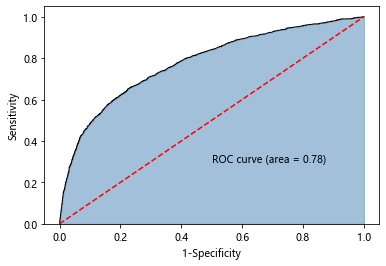

In [3]:
y_score = AdaBoost1.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

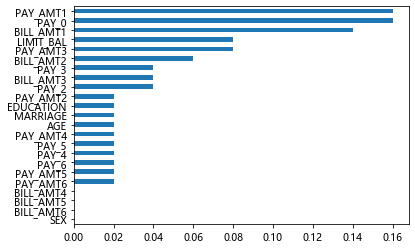

In [4]:
# 自变量的重要性排序
importance = pd.Series(AdaBoost1.feature_importances_, index = X.columns)
importance.sort_values().plot(kind = 'barh')
plt.show()

In [5]:
# 取重要性比较高的自变量建模
predictors = list(importance[importance>0.02].index)
predictors

# 网格搜索法选择基础模型所对应的合理参数组合
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

max_depth = [3,4,5,6]
params1 = {'base_estimator__max_depth':max_depth}
base_model = GridSearchCV(estimator = ensemble.AdaBoostClassifier(base_estimator = DecisionTreeClassifier()),
                          param_grid= params1, scoring = 'roc_auc', cv = 5, n_jobs = 4, verbose = 1)
base_model.fit(X_train[predictors],y_train)
# 返回参数的最佳组合和对应AUC值
base_model.best_params_, base_model.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.2s finished


({'base_estimator__max_depth': 3}, 0.7412473612346481)

In [6]:
# 通过网格搜索法选择提升树的合理参数组合
from sklearn.model_selection import GridSearchCV

n_estimators = [100,200,300]
learning_rate = [0.01,0.05,0.1,0.2]
params2 = {'n_estimators':n_estimators,'learning_rate':learning_rate}
adaboost = GridSearchCV(estimator = ensemble.AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3)),
                        param_grid= params2, scoring = 'roc_auc', cv = 5, n_jobs = 4, verbose = 1)
adaboost.fit(X_train[predictors] ,y_train)
# 返回参数的最佳组合和对应AUC值
adaboost.best_params_, adaboost.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  4.1min finished


({'learning_rate': 0.05, 'n_estimators': 100}, 0.7695734381779731)

In [7]:
# 使用最佳的参数组合构建AdaBoost模型
AdaBoost2 = ensemble.AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3),
                                       n_estimators = 300, learning_rate = 0.01)
AdaBoost2.fit(X_train[predictors],y_train)
pred2 = AdaBoost2.predict(X_test[predictors])

print('模型的准确率为：\n',metrics.accuracy_score(y_test, pred2))
print('模型的评估报告：\n',metrics.classification_report(y_test, pred2))

模型的准确率为：
 0.816
模型的评估报告：
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5800
           1       0.69      0.34      0.45      1700

    accuracy                           0.82      7500
   macro avg       0.76      0.65      0.67      7500
weighted avg       0.80      0.82      0.79      7500



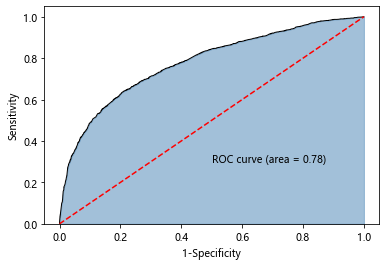

In [8]:
# 计算正例的预测概率，用于生成ROC曲线的数据
y_score = AdaBoost2.predict_proba(X_test[predictors])[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [9]:
# 提升树
# 运用网格搜索法选择梯度提升树的合理参数组合
learning_rate = [0.01,0.05,0.1,0.2]
n_estimators = [100,300,500]
max_depth = [3,4,5,6]
params = {'learning_rate':learning_rate,'n_estimators':n_estimators,'max_depth':max_depth}
gbdt_grid = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(),
                         param_grid= params, scoring = 'roc_auc', cv = 5, n_jobs = 4, verbose = 1)
gbdt_grid.fit(X_train[predictors],y_train)
# 返回参数的最佳组合和对应AUC值
gbdt_grid.best_params_, gbdt_grid.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 21.6min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 27.5min finished


({'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
 0.774507964422411)

In [10]:
# 基于最佳参数组合的GBDT模型，对测试数据集进行预测
pred = gbdt_grid.predict(X_test[predictors])
print('模型的准确率为：\n',metrics.accuracy_score(y_test, pred))
print('模型的评估报告：\n',metrics.classification_report(y_test, pred))

模型的准确率为：
 0.8134666666666667
模型的评估报告：
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      5800
           1       0.67      0.35      0.46      1700

    accuracy                           0.81      7500
   macro avg       0.75      0.65      0.67      7500
weighted avg       0.80      0.81      0.79      7500



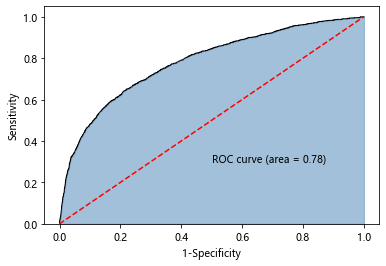

In [11]:
# 计算违约客户的概率值，用于生成ROC曲线的数据
y_score = gbdt_grid.predict_proba(X_test[predictors])[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [12]:

creditcard = pd.read_csv(r'creditcard.csv')

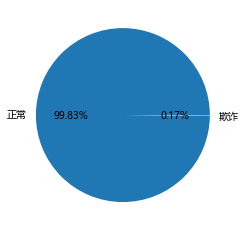

In [13]:
plt.axes(aspect = 'equal')
counts = creditcard.Class.value_counts()
plt.pie(x = counts, 
        labels=pd.Series(counts.index).map({0:'正常',1:'欺诈'}),
        autopct='%.2f%%'
       )
plt.show()

In [14]:
X = creditcard.drop(['Time','Class'], axis = 1)
y = creditcard.Class
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size = 0.3, random_state = 1234)

In [15]:
from imblearn.over_sampling import SMOTE

# 运用SMOTE算法实现训练数据集的平衡
over_samples = SMOTE(random_state=1234) 
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train)
#over_samples_X, over_samples_y = over_samples.fit_sample(X_train.values,y_train.values.ravel())
# 重抽样前的类别比例
print(y_train.value_counts()/len(y_train))
# 重抽样后的类别比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0    0.998239
1    0.001761
Name: Class, dtype: float64
1    0.5
0    0.5
Name: Class, dtype: float64


In [17]:
import xgboost
import numpy as np
# XGBoost分类器
xgboost = xgboost.XGBClassifier()
xgboost.fit(over_samples_X,over_samples_y)
resample_pred = xgboost.predict(X_test)

# 返回模型的预测效果
print('模型的准确率为：\n',metrics.accuracy_score(y_test, resample_pred))
print('模型的评估报告：\n',metrics.classification_report(y_test, resample_pred))

模型的准确率为：
 0.9992977774656788
模型的评估报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.78      0.81      0.79       141

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443



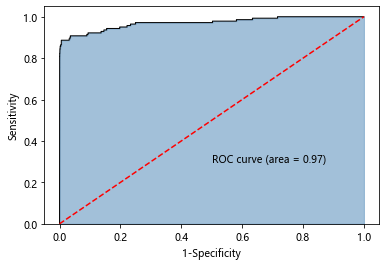

In [19]:
# 计算欺诈交易的概率值，用于生成ROC曲线的数据
y_score = xgboost.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [24]:
import xgboost
xgboost2 = xgboost.XGBClassifier()
xgboost2.fit(X_train,y_train)
pred2 = xgboost2.predict(X_test)
display(pd.crosstab(pred2,y_test))

print('模型的准确率为：\n',metrics.accuracy_score(y_test, pred2))
print('模型的评估报告：\n',metrics.classification_report(y_test, pred2))

Class,0,1
row_0,,
0,85292,32
1,10,109


模型的准确率为：
 0.9995084442259752
模型的评估报告：
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.92      0.77      0.84       141

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



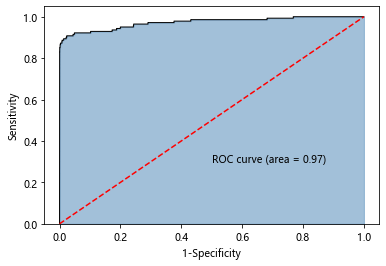

In [25]:
# 计算欺诈交易的概率值，用于生成ROC曲线的数据
y_score = xgboost2.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)


plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()